## Imports

In [1]:
import sys
import numba
import numpy as np
import pandas as pd
from math import e
from os.path import abspath, join as opj
from scipy.stats import pearsonr
from tqdm.notebook import tqdm
from umap import UMAP

sys.path.insert(0, abspath('../helpers/'))
from participant import Participant, symmetric_kl
from experiment import Experiment

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Set paths & params

In [2]:
embeddings_dir = '../../data/embeddings'
models_dir = '../../data/models/'
fig_dir = '../../paper/figs/'

plt.rcParams['pdf.fonttype'] = 42
sns.set_context('paper')
# cmap = 'rocket'

## Define functions

In [3]:
# def interp_inv_transform(xy_coords, topic_props):
#     """
#     given a (n_xcoords, n_ycoords, xy_coords) grid of coordinates
#     and a (n_xcoords, n_ycoords, ndims) grid of topic vectors,
#     interpolate topic proportions at xy_coords where UMAP inverse
#     transform failed (i.e., returned a topic vector of all zeros)
#     """
#     err_mask = np.all(np.equal(topic_props, 0), axis=2)
#     good_coords = xy_coords[~err_mask]
#     err_coords = xy_coords[err_mask]
#     good_vectors = topic_props[~err_mask]
#     interpolator = LinearNDInterpolator(good_coords, good_vectors)
#     fixed_vals = interpolator(err_coords)
#     topic_props[err_mask] = fixed_vals
#     return topic_props

## Load data

In [9]:
exp = Experiment()
exp.load_lecture_trajs()
exp.load_question_vectors()
exp.load_participants(load_avg=True)
participants = exp.participants
avg_participant = exp.avg_participant
n_topics = exp.lda_params['n_components']
umap_params = exp.umap_params
seed = umap_params['random_state']
print(umap_params)

{'n_components': 2, 'n_neighbors': 15, 'min_dist': 0.7, 'spread': 1.0, 'random_state': 0, 'metric': 'll_dirichlet'}


## Create 2D embeddings

In [10]:
# concatenate all data along fetaure dimension to embed in a shared space
to_reduce = exp.get_lecture_traj(['forces', 'bos'])
to_reduce.extend(list(exp.get_question_vecs(lectures=['forces', 'bos', 'general'])))
# store data incidces to separate embedded matrix later
split_inds = np.cumsum([np.atleast_2d(vec).shape[0] for vec in to_reduce])[:2]
to_reduce = np.log(np.vstack(to_reduce))

In [12]:
np.random.seed(seed)
reducer = UMAP(verbose=True, **umap_params).fit(to_reduce)
embeddings = reducer.embedding_
forces_emb, bos_emb, questions_embs = np.vsplit(embeddings, split_inds)

/opt/conda/lib/python3.7/site-packages/umap/umap_.py:1529: UserWarning: gradient function is not yet implemented for ll_dirichlet distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


UMAP(a=None, angular_rp_forest=True, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='ll_dirichlet',
     metric_kwds=None, min_dist=0.7, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Thu Mar  5 17:50:11 2020 Finding Nearest Neighbors
Thu Mar  5 17:50:14 2020 Finished Nearest Neighbor Search
Thu Mar  5 17:50:16 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed 

In [12]:
# save fit UMAP reducer and 2D embeddings
# np.save(opj(models_dir, 'UMAP_reducer'), reducer)
# np.save(opj(embeddings_dir, 'forces_lecture'), forces_emb)
# np.save(opj(embeddings_dir, 'bos_lecture'), bos_emb)
# np.save(opj(embeddings_dir, 'questions'), questions_embs)
# exp.load_reducer()
# exp.load_embeddings()

## Create a 2D grid

In [13]:
resolution = 50
x_min, y_min = embeddings.min(axis=0) // 1
x_max, y_max = embeddings.max(axis=0) // 1 + 1
x_step = (x_max - x_min) / resolution
y_step = (y_max - y_min) / resolution
xs = np.arange(x_min, x_max, x_step)
ys = np.arange(y_min, y_max, y_step)

X, Y = np.meshgrid(xs, ys)
xy_grid = np.empty((resolution, resolution, 2), dtype=np.float64)
for (x_ix, y_ix), X_val in np.ndenumerate(X):
    xy_grid[x_ix, y_ix] = (X_val, Y[x_ix, y_ix])

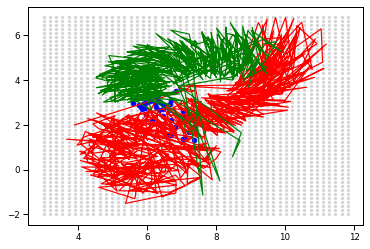

In [14]:
vertices = xy_grid.reshape(resolution**2, 2)

plt.scatter(vertices[:, 0], vertices[:, 1], c='lightgrey', marker='.')
plt.plot(forces_emb[:, 0], forces_emb[:, 1], 'r-')
plt.plot(bos_emb[:, 0], bos_emb[:, 1], 'g-')
plt.scatter(questions_embs[:, 0], questions_embs[:, 1], c='b', marker='o')

## Recover a topic vector for each grid point

In [52]:
# inverse-transform grid into original topic space
np.random.seed(42)
topic_space_grid = reducer.inverse_transform(vertices.astype(np.float32)).reshape(resolution, resolution, n_topics)
# make sure inverse transform was successful at all coordinates (failure returns all 0's)
assert ~np.all(np.equal(topic_space_grid, 0), axis=2).any()

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mInvalid use of type(CPUDispatcher(<function euclidean_exp at 0x7f52a95cf3b0>)) with parameters (array(float32, 1d, C), array(float32, 1d, C))
 * parameterized[0m
[0m[1m[1] During: resolving callee type: type(CPUDispatcher(<function euclidean_exp at 0x7f52a95cf3b0>))[0m
[0m[1m[2] During: typing of call at /opt/conda/lib/python3.7/site-packages/umap/layouts.py (506)
[0m
[1m
File "../../../opt/conda/lib/python3.7/site-packages/umap/layouts.py", line 506:[0m
[1mdef optimize_layout_inverse(
    <source elided>
                dist_output, grad_dist_output = output_metric(
[1m                    current, other, *output_metric_kwds
[0m                    [1m^[0m[0m

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/latest/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/latest/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


In [85]:
vertices = vertices.astype(np.float32)

In [87]:
reducer._input_distance_func

CPUDispatcher(<function euclidean_exp at 0x7f6e35575f80>)

In [218]:
np.sort(np.abs(vertices.astype(np.float32)).ravel())

array([2.0526280e-03, 2.8510019e-03, 3.0582405e-03, ..., 1.8764999e+14,
       1.8764999e+14, 1.8764999e+14], dtype=float32)

In [221]:
for i in range(vertices.shape[0]):
    for j in range(vertices.shape[1]):
#         if np.abs(vertices[i, j]) < 1e-10:
#             vertices[i, j] =  1 / vertices[i, j]
        vertices[i, j] += np.random.uniform(-10, 10, 1)
#             vertices[i, j] = np.random.uniform(1, 2, 1)

In [223]:
vertices += np.random.uniform(-10, 10, vertices.shape)

In [192]:
for _ in range(5):
    print(np.random.uniform(-6, 6, 1))

[0.58576205]
[2.5822724]
[1.23316051]
[0.5385982]
[-0.91614241]


In [77]:
vertices[np.where(np.abs(vertices) < 1e-4)] = np.random.rand(1)

In [120]:
np.unique(vertices.astype(np.float32), axis=0).shape

(2500, 2)

In [121]:
for i in vertices.astype(np.float32):
    if i[0] == i[1]:
        i[1] += np.random.rand(1)

In [114]:
vertices.astype(np.float32)

array([[-9.  , -9.  ],
       [-8.34, -9.  ],
       [-7.68, -9.  ],
       ...,
       [22.02, 20.4 ],
       [22.68, 20.4 ],
       [23.34, 20.4 ]], dtype=float32)

In [126]:
to_reduce.dtype

dtype('float64')

In [35]:
from umap.layouts import optimize_layout_inverse, 
from umap.umap_ import inverse_transform

In [123]:
reducer.inverse_transform(reducer.embedding_)

array([[-0.03724295,  0.03868928,  0.01923369, ..., -0.02604701,
         0.19172178, -0.05930637],
       [-0.00582121,  0.02614689, -0.00023228, ..., -0.026667  ,
         0.21516909, -0.06192578],
       [-0.0270627 ,  0.0810365 , -0.02109524, ..., -0.04879716,
         0.2033397 , -0.07641315],
       ...,
       [ 0.0265813 ,  0.04651811,  0.05270546, ..., -0.01273792,
        -0.02440088,  0.16454573],
       [-0.03103826, -0.00832056,  0.04724101, ...,  0.04609781,
         0.08957766,  0.00643705],
       [-0.00392148, -0.02371107, -0.02202489, ...,  0.10131297,
        -0.03077328, -0.00627229]], dtype=float32)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.7, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)

In [38]:
np.random.seed(seed)
reducer.inverse_transform(reducer.embedding_)

array([[ 0.0358215 ,  0.00634138,  0.01782341, ..., -0.02453398,
         0.18436453, -0.03685992],
       [ 0.01850212,  0.0245776 , -0.00340517, ..., -0.01188557,
         0.17549121, -0.05860209],
       [ 0.03474272,  0.00771746,  0.01320461, ..., -0.04489234,
         0.15640609, -0.0817729 ],
       ...,
       [-0.01317229,  0.10985884,  0.062901  , ..., -0.01452171,
        -0.03514386,  0.13993178],
       [-0.01152492,  0.02010768,  0.07275306, ..., -0.01321308,
         0.05595402, -0.03784548],
       [ 0.015407  ,  0.0110328 ,  0.05815401, ...,  0.1785727 ,
         0.02823636,  0.06588855]], dtype=float32)

In [39]:
reducer._raw_data

array([[   25.94118 ,   -37.499958,   -37.43527 , ...,   -37.23271 ,
           25.86701 ,    25.940058],
       [ -137.71486 ,  -137.5875  ,   272.8169  , ...,  -137.61237 ,
         -137.57426 ,  -137.39403 ],
       [ -474.1665  ,   461.25525 ,  -474.71265 , ...,   461.2093  ,
         -474.72534 ,  -474.80472 ],
       ...,
       [ -711.81647 ,  -759.77454 ,   767.3281  , ...,  -526.1649  ,
         -798.44934 ,   755.9126  ],
       [-1019.9251  ,  1003.77527 ,  1006.72125 , ..., -1026.7367  ,
        -1019.8356  , -1028.4554  ],
       [   91.80331 ,    91.630516,    91.871414, ...,   -73.24754 ,
          -72.81444 ,   -72.80946 ]], dtype=float32)

## Reconstruct memory traces for every grid point

In [73]:
flat_topic_grid = topic_space_grid.reshape(resolution**2, n_topics)

maps_arr = np.empty((3, 50, resolution, resolution), dtype=np.float64)
for qset in range(3):
    store_key = f'kmap_qset{qset}'
    for i, p in enumerate(tqdm(participants, desc=f'{qset+1}/3', leave=False)):
        knowledge_map = p.reconstruct_trace(exp, content=flat_topic_grid, qset=qset)
        knowledge_map = knowledge_map.reshape(resolution, resolution)
        p.store_trace(knowledge_map, store_key)
        maps_arr[qset, i] = knowledge_map
    # store average in avg participant object
    avg_participant.store_trace(maps_arr[qset].mean(axis=0), store_key)

# exp.participants = participants
# exp.avg_participant = avg_participant

In [164]:
p = participants[0]
data = p.get_data(qset=0, lecture=None)
acc = data['accuracy'].astype(bool)
qids = data['qID'].tolist()
question_vecs = exp.get_question_vecs(qids=qids)
content = flat_topic_grid

In [159]:
bads = []
for p in participants:
    for qset in range(1,3):
        data = p.get_data(qset=list(range(qset + 1)), lecture=None)
        qids = data['qID'].tolist()
        question_vecs = exp.get_question_vecs(qids=qids)
        wz = cdist(content, question_vecs, metric=symmetric_kl).flatten()
        bad = len(np.where(np.equal(wz, np.inf))[0]) / len(wz)
        print(bad)
        bads.append(bad)
        


0.5308
0.5308
0.5308
0.5308
0.5308
0.5308
0.5308
0.5308
0.5308


KeyboardInterrupt: 

In [124]:
from scipy.stats import entropy

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       ...,
       [ True,  True],
       [ True,  True],
       [ True,  True]])

'0.45.1'

In [127]:
content[np.where(np.equal(wz, np.inf))[0]][0]

array([ 0.08828227, -0.07281294,  0.08828227,  0.08828227,  0.08828227,
        0.08828227,  0.08828227,  0.08828227,  0.08828227,  0.08828227,
        0.08828227,  0.08828227,  0.08828227,  1.0152799 ,  0.08828227,
        0.08828227,  0.1269502 ,  0.08828227,  0.10972431,  0.08828227,
        0.08828227,  0.08828227,  0.10595456,  0.08828227,  0.08828227],
      dtype=float32)

In [130]:
question_vecs[0]

array([0.18545455, 0.00363636, 0.00363636, 0.00363636, 0.00363636,
       0.00363636, 0.00363636, 0.00363636, 0.00363636, 0.00363636,
       0.00363636, 0.00363636, 0.00363636, 0.00363636, 0.00363636,
       0.18545455, 0.00363636, 0.00363636, 0.32611456, 0.00363636,
       0.00363636, 0.00363636, 0.00363636, 0.22661271, 0.00363636])

In [171]:
entropy(content[np.where(np.equal(wz, np.inf))[0]][0] + .08, question_vecs[0] + .08)

0.41700394840480964

In [175]:
entropy(content[np.where(np.equal(wz, np.inf))[0]][0] + .08, question_vecs[0] + .08)

0.41700394840480964

In [177]:
content[np.where(np.equal(wz, np.inf))[0]][0] + .07

array([ 0.15828228, -0.00281294,  0.15828228,  0.15828228,  0.15828228,
        0.15828228,  0.15828228,  0.15828228,  0.15828228,  0.15828228,
        0.15828228,  0.15828228,  0.15828228,  1.08528   ,  0.15828228,
        0.15828228,  0.1969502 ,  0.15828228,  0.1797243 ,  0.15828228,
        0.15828228,  0.15828228,  0.17595455,  0.15828228,  0.15828228],
      dtype=float32)

In [209]:
test = np.zeros_like(topic_space_grid)
test[np.where(topic_space_grid <= 0)] = 1
test[np.where(topic_space_grid >= 1)] = 1


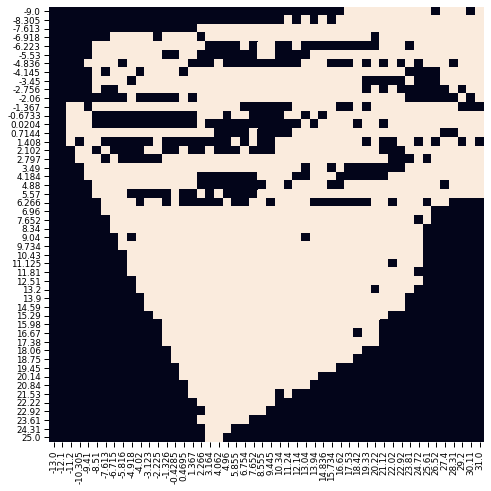

In [232]:
fig, ax = plt.subplots(1)
fig.set_size_inches(8, 8)
ax = sns.heatmap(test.max(2), 
            xticklabels=np.linspace(-13, 31, 50, dtype=np.float16), 
            yticklabels=np.linspace(-9, 25, 50, dtype=np.float16), ax=ax, square=True, cbar=False)

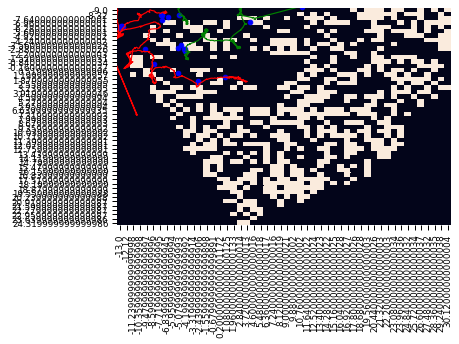

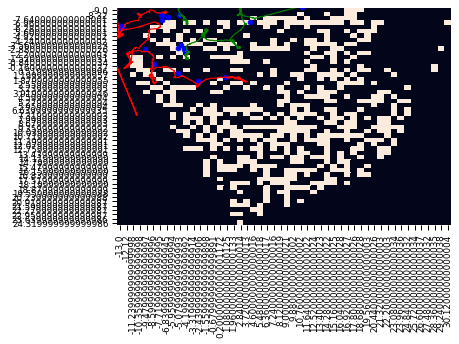

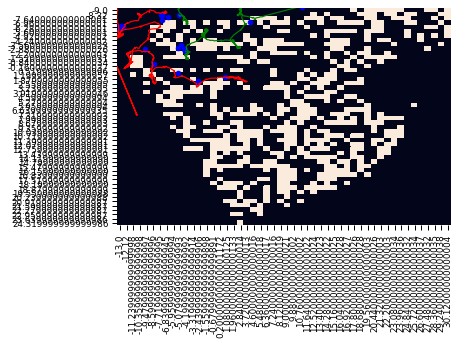

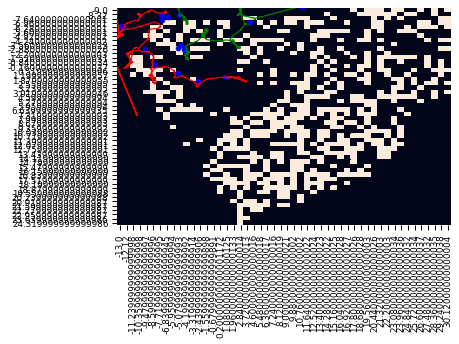

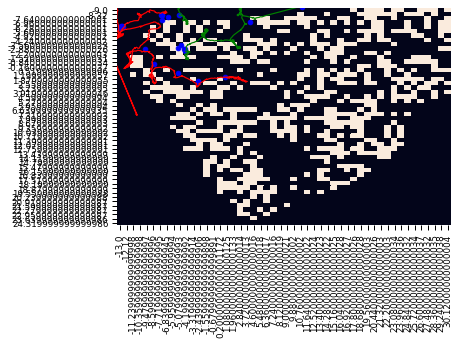

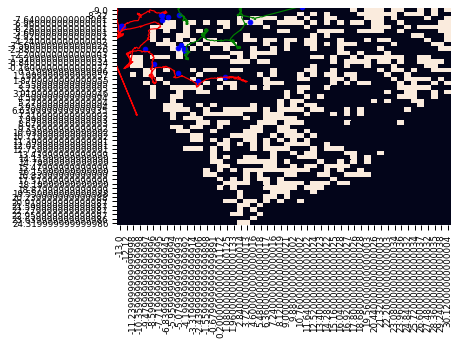

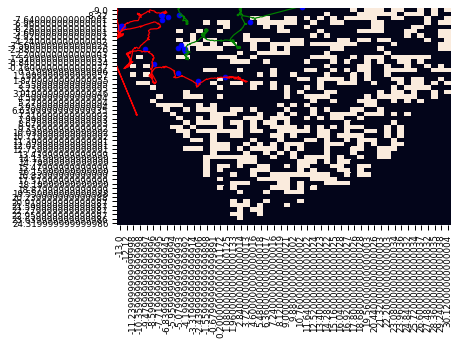

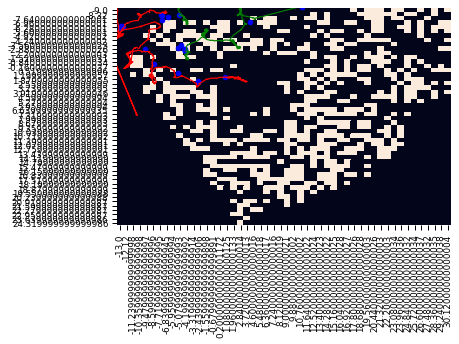

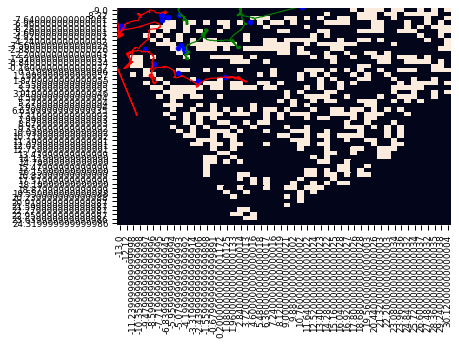

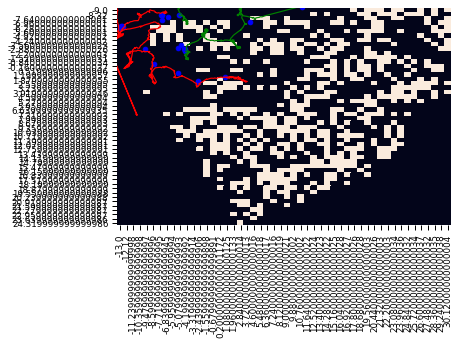

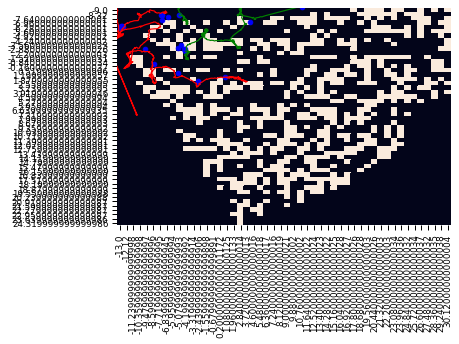

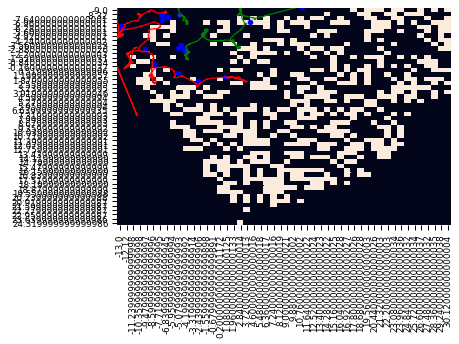

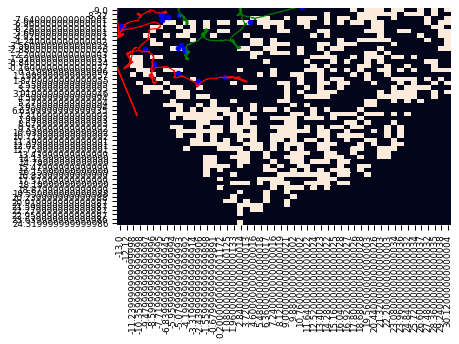

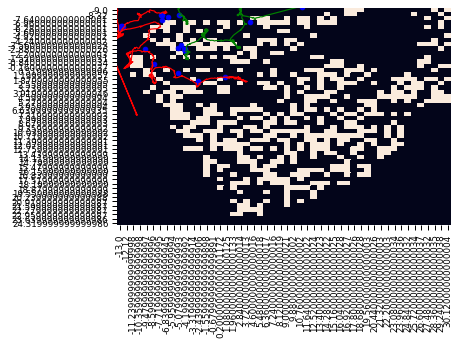

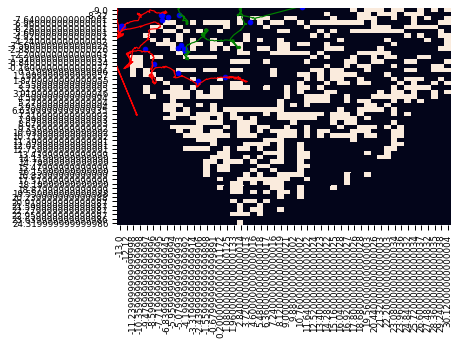

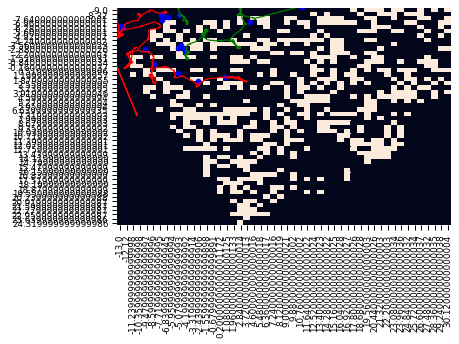

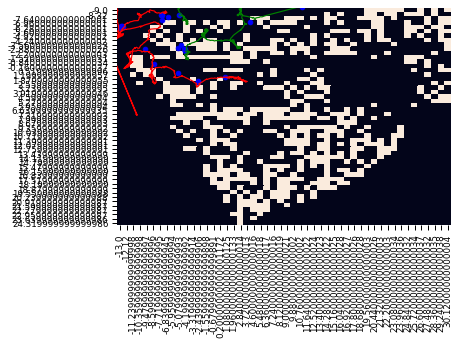

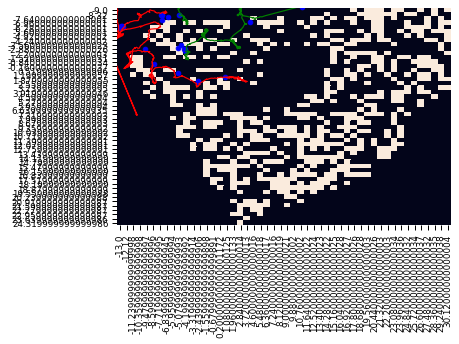

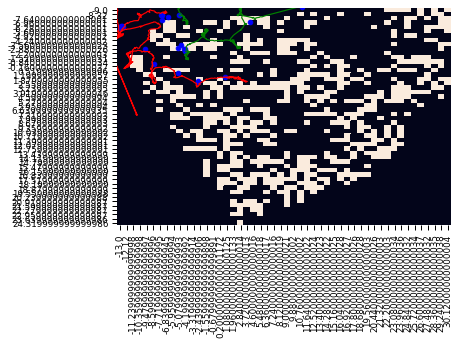

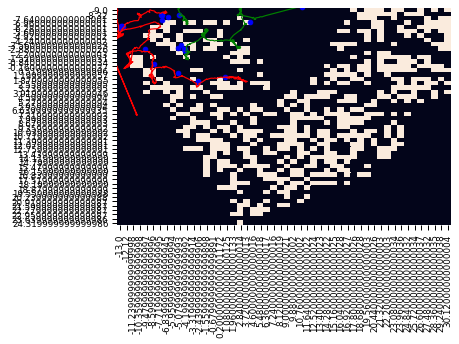

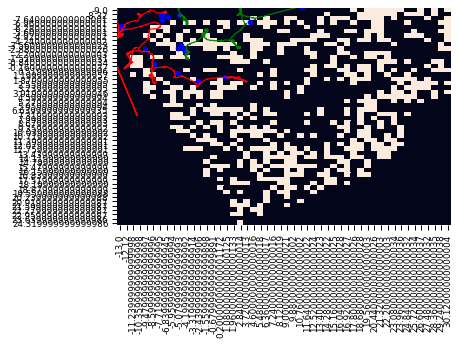

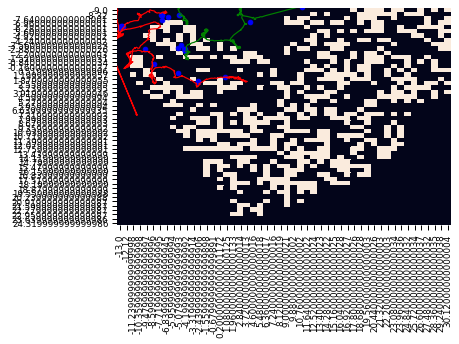

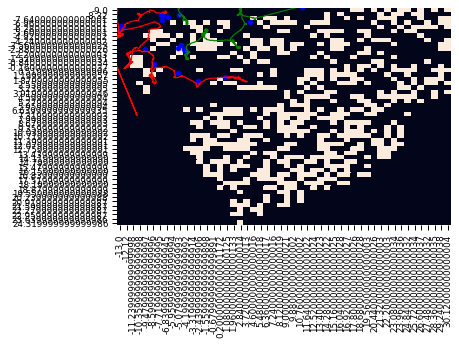

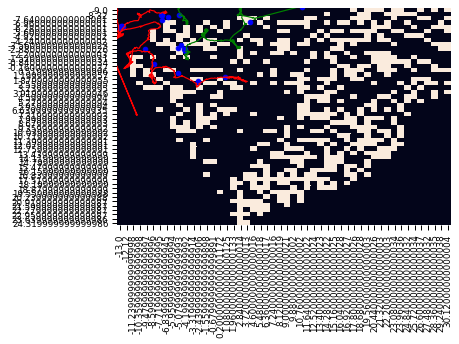

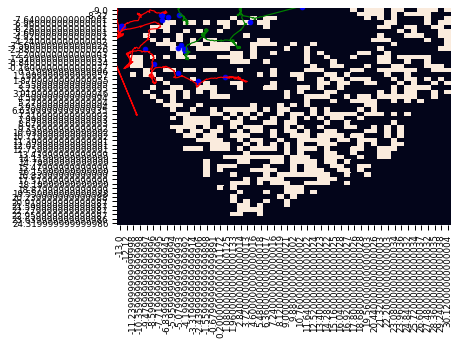

In [249]:
for i in range(25):
    fig, ax = plt.subplots(1)
    ax = sns.heatmap(test[:, :, i], cbar=False, 
                     xticklabels=np.arange(x_min, x_max, x_step), 
                     yticklabels=np.arange(y_min, y_max, y_step), 
                     ax=ax)
    ax.plot(forces_emb[:, 0], forces_emb[:, 1], 'r-')
    ax.plot(bos_emb[:, 0], bos_emb[:, 1], 'g-')
    ax.scatter(questions_embs[:, 0], questions_embs[:, 1], c='b', marker='o')
    plt.show()

25.0

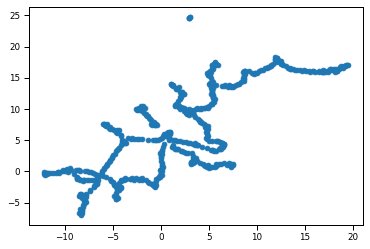

In [30]:
plt.scatter(forces_emb[:, 0], forces_emb[:, 1])

In [671]:
n_questions = len(questions_df.loc[questions_df.video.isin([1, 2])])
participant_IDs = sorted(data_df.participantID.unique())

In [672]:
question_corr_grid = np.empty((n_questions, X.shape[0], X.shape[1]))
all_questions_vectors = list(forces_qs) + list(bos_qs)

for q_n, q_vector in enumerate(all_questions_vectors):
    for x_ix in range(X.shape[0]):
        for y_ix in range(X.shape[1]):
            question_corr_grid[q_n, x_ix, y_ix] = pearsonr(q_vector, topic_space_grid[x_ix, y_ix])[0]

In [681]:
for set_n in range(3):
    questions_pcorrect = np.empty(n_questions)
    for question in range(n_questions):
        # questions 1 - 30 pertain to lectures
        set_views = data_df.loc[(data_df.qID == question + 1) & (data_df['set'] == set_n)]
        p_correct = len(set_views.loc[set_views['correct?'] == 1]) / len(set_views)
        questions_pcorrect[question] = p_correct
        
    # compute weighted proportion of correctly answered questions for ecah grid point
    # weights are correlation between grid point topic vector and question vector
    knowledge_grid = np.zeros_like(X)
    weight_sum = question_corr_grid.sum(axis=0)
    knowledge_grid = (questions_pcorrect * question_corr_grid.T).sum(axis=2) / weight_sum
    break
    

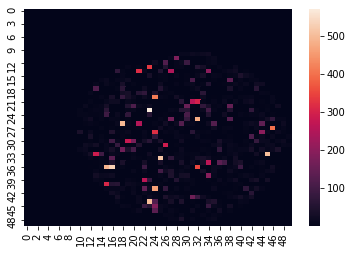

In [649]:
sns.heatmap(topic_space_grid.var(axis=2))

In [644]:
np.var

array([0.00152635, 0.00152631, 0.0015263 , 0.00152632, 0.00152629,
       0.0015263 , 0.0015263 , 0.00356824, 0.20046054, 0.00152631,
       0.5624761 , 0.0015263 ], dtype=float32)

In [639]:
q_vector

array([0.86904477, 0.01190482, 0.01190477, 0.01190477, 0.0119048 ,
       0.01190521, 0.01190477, 0.01190485, 0.01190527, 0.01190521,
       0.01190529, 0.01190548])

In [635]:
question_corr_grid[0, 0]

array([0.90198459, 0.90198457, 0.90198459, 0.90198457, 0.9019846 ,
       0.90198459, 0.90198458, 0.9019846 , 0.90198459, 0.90198458,
       0.90198462, 0.90198461, 0.90198461, 0.90198461, 0.90198457,
       0.90198461, 0.90198458, 0.90198461, 0.90198461, 0.90198461,
       0.90198461, 0.90198458, 0.90198459, 0.90198459, 0.90198458,
       0.9019846 , 0.90198459, 0.90198461, 0.90198462, 0.90198459,
       0.90198463, 0.90198458, 0.90198458, 0.90198459, 0.90198459,
       0.90198459, 0.90198459, 0.90198459, 0.90198459, 0.90198456,
       0.90198456, 0.90198456, 0.90198456, 0.90198464, 0.90198457,
       0.90198463, 0.9019846 , 0.90198461, 0.90198461, 0.90198463])

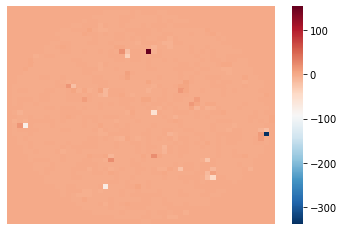

In [682]:
sns.heatmap(knowledge_grid, cmap=plt.cm.RdBu_r, xticklabels=[], yticklabels=[])
plt.show()

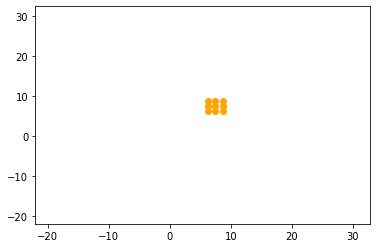

In [335]:
plt.scatter(np.vstack(embeddings)[:, 0], np.vstack(embeddings)[:, 1], c='white')
plt.scatter(all_zeros[:, 0], all_zeros[:, 1], c='orange')
plt.show()